# Further work with confocal image datasets

## Introduction

Yesterday you worked with some statistics extracted from an Imaris file. Today,
you will learn how to work directly with the file to extract additional
information. 

Imaris is an open-source file format based on HDF5. A number of languages have
packages for reading this file format. For Python, there are two main packages,
`h5py` and `pytables`. We will use `pytables` for this exercise.

## The data

Up to 25 auditory nerve fibers synapse onto individual inner hair cells in
normal-hearing individuals. However, these synapses can be permanently lost due
to aging, exposure to noise or ototoxic drugs.  In experiments that study
hearing loss, we need a way of quantifying the number of synapses per inner
hair cell.

One approach is to dissect the cochlea out of the experimental animals and use
whole-mount immunohistochemistry to label the tissue with antibodies for
pre-synaptic ribbons (CtBP2), post-synaptic receptors (GluR2) and cytoskeleton
(Myosin VIIa). In a second step, each antibody is tagged with a fluorescent dye
that can be illuminated using a laser (much like how a black light can cause
certain materials to glow).

The distribution of these fluorescent dyes (which map to the underlying
distribution of the proteins of interest) can be captured by taking a series of
two-dimensional images at various depths in the tissue.  These images are then
"stacked" to create a three-dimensional image known as a Z-stack (since the
third dimension is commonly referred to as the Z-axis).

For this exercise, the dataset has been trimmed down to a small subset showing
only two inner hair cells (the full dataset is 0.5 GB in size) with CtBP2 (fig.
1a) and GluR2 (fig. 1b).

<table>
	<body>
		<tr>
			<td>1A. CtBP2 (pre-synaptic ribbon)</td>
			<td>1B. GluR2 (post-synaptic glutamate receptor)</td>
		</tr>
		<tr>
			<td><img src="data/CtBP2.png" /></td>
			<td><img src="data/GluR2.png" /></td>
		</tr>
	</body>
</table>

## The problem

A functional inner hair cell synapse requires both a pre-synaptic ribbon and a
post-synaptic glutamate receptor. The next step in our analysis is to determine
whether each CtBP2 puncta is near a GluR2 label. 

This dataset was analyzed using Imaris to identify all CtBP2 puncta (white dots
in fig. 2a). If you look closely at the composite (fig. 2b), you'll see that
not all puncta have a glutamate receptor patch next to them (fig. 2b)! We
should not be counting these for the purpose of analysis. So, we need to find a
way to detect these false hits and eliminate them.

<table>
	<body>
		<tr>
			<td>A. CtBP2 puncta</td>
			<td>B. CtBP2 puncta overlaid on GluR2</td>
		</tr>
		<tr>
			<td><img src="data/CtBP2+points.png" /></td>
			<td><img src="data/CtBP2+GluR2+points.png" /></td>
		</tr>
	</body>
</table>

One approach is to extract a fixed volume around each CtBP2 puncta (e.g., a 1um
cube) and quantify the amount of GluR2 label in the volume. But, we don't know
very much about the format of the data. We need to do a little exploration
first.

First, let's import a few modules we'll need. Most of them are common third-party modules; however, I have written a helper module (`imaris`) to extract some of the data on the CtBP2 puncta from the file (you loaded this data from a comma-separated-values file yesterday; however, we are now going to load it directly from the HDF5 file itself).

In [1]:
import pylab as pl
import tables as tb
import numpy as np

import imaris

%matplotlib inline

Now, let's open the file.

In [2]:
fh = tb.open_file('data/confocal dataset.ims')

We need to figure out how to find the image data. We can start by taking a look at the file. Since HDF5 is a hierarchial data format, data inside the file is stored in a tree-like structure. We can view this structure using `print`.

In [3]:
print(fh)

data/confocal dataset.ims (File) ''
Last modif.: 'Wed Dec 13 10:50:49 2017'
Object Tree: 
/ (RootGroup) ''
/DataSet (Group) ''
/DataSetInfo (Group) ''
/DataSetTimes (Group) ''
/DataSetTimes/Time (Table(1,)) ''
/DataSetTimes/TimeBegin (Table(1,)) ''
/Scene (Group) ''
/Scene/Data (VLArray(1,)) ''
/Scene8 (Group) ''
/Scene8/Data (VLArray(1,)) ''
/Thumbnail (Group) ''
/Thumbnail/Data (Array(194, 776)) ''
/Scene8/Content (Group) ''
/Scene8/Content/Points0 (Group) ''
/Scene8/Content/Points0/Category (Table(2,)) ''
/Scene8/Content/Points0/Factor (Table(6,)) ''
/Scene8/Content/Points0/FactorList (Table(6,)) ''
/Scene8/Content/Points0/LabelGroupNames (Table(0,)) ''
/Scene8/Content/Points0/LabelSetLabelIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSetObjectIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSets (Table(0,)) ''
/Scene8/Content/Points0/LabelValues (Table(0,)) ''
/Scene8/Content/Points0/MainTrackSegmentTable (Table(1,)) ''
/Scene8/Content/Points0/Spot (Table(47,)) ''
/Scene8/Content/

This is a lot of information! However, in scanning the list there are several
things that jump out as important clues. First, remember that the tissue has
three labels (CtBP2, GluR2 and MyosinVIIa). In confocal imaging, each label is
acquired using a separate channel. At the bottom of the list we see several
rows that mention `Channel 0`, `Channel 1` and `Channel 2`. This is most likely
the data we need.

However, the channels appear several times (under `ResolutionLevel 0`,
`ResolutionLevel 1`). Which one do we want? Our
intuition as a programmer tells us that Imaris likely generates the dataset at
multiple resolutions and uses the appropriate resolution based on your zoom
level. For quantitative analysis, we probably want the highest resolution
level. 

Take another look at the list. You'll notice that at the end of each line
there's an indicator in parenthesis (`Group`, `Array`, `CArray`). These are the
different types of nodes (i.e., entries) in the HDF5 file. The simplest way to
think of a HDF5 file is that it's a self-contained filesystem. A `group` node
is equivalent to a folder. A `leaf` node (e.g., `Array`, `CArray`, `Table`) is
equivalent to a file. Group nodes are used to organize the data in the HDF5
file.

Now, let's look at the `Channel 0/Data` line for each resolution level. There's
some information about the size of the array. This tells us that
`ResolutionLevel 0` contains the highest resolution data and `ResolutionLevel
2` contains the lowest resolution data. Otherwise, they should be identical.

Let's take a look at a single node so we can understand how to work with
the data.

In [4]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data')
data_CtBP2 = node.read()
print(data_CtBP2.shape)

(144, 256, 256)


This is a 3D `numpy` array. Based on how the data was acquired and processed, the shortest dimension is the Z-axis. This suggests the first axis represents the Z dimension.

There are ways to visualize 3D data in Python. However, these approaches are
not readily available out of the box for Jupyter notebooks. Let's focus on simple 2D plotting
instead. A common way of presenting confocal image stacks is to take the
maximum projection along an an axis (i.e., dimension). Let's take the maximum
projection along the first axis (i.e., Z-axis) and plot the resulting 2D image using `imshow`.

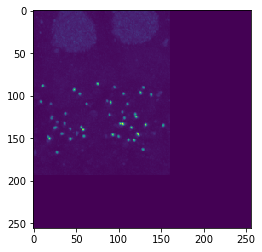

In [5]:
projection = data_CtBP2.max(axis=0)
pl.imshow(projection)

It looks like the image has been "padded" with empty data by Imaris, making it a bit ugly to look at. Let's crop out that extra data. To do this, we need to find out what the actual image extents are in pixels. There is a way to do this by looking at the HDF5 file, but this is outside the scope of the exercise. For now, we provide the numbers for you.

Using these numbers, let's trim down the array to exclude these regions and redo the projection.

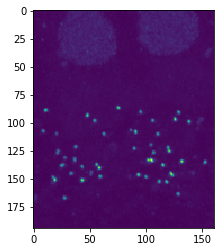

In [6]:
x_pixels = 161
y_pixels = 194
z_pixels = 135

data_CtBP2 = data_CtBP2[:z_pixels, :y_pixels, :x_pixels]
projection_cropped = data_CtBP2.max(axis=0)
pl.imshow(projection_cropped)

The units on the X and Y-axes are in pixels. Let's convert them to actual image dimensions (in microns). How do we do this? Let's take a look at the documentation for `imshow` for clues. Remember that you can look up documentation by putting a `?` after the name of the function and executing the cell.

In [7]:
pl.imshow?

The description for the `extent` argument looks very promising. It takes the dimensions of the image in data-coordinates (right, left, top, bottom). To do this, we need to know the image extents in microns. Again, this can be done by checking the HDF5 file (they are stored as attributes on `/DataSetInfo/Image`), but for now we provide the numbers for you.

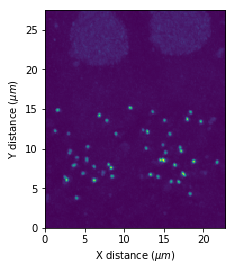

In [8]:
x_um = 22.7418
y_um = 27.442
z_um = 21.526

# extent
extent = (0, x_um, 0, y_um)
pl.imshow(projection_cropped, extent=extent)
pl.xlabel('X distance ($\mu m$)')
pl.ylabel('Y distance ($\mu m$)')

Now, we need to load the data about the CtBP2 puncta that were identified using Imaris. Specifically, we need to know the XYZ location of each puncta. A helper function is provided to extract this information from the Imaris file.

In [9]:
stats_CtBP2 = imaris.load_node_stats(fh, 'CtBP2', 'point')
stats_CtBP2.head()

name,X,Y,Z
id_object,,,
0,6.832067,13.227180,3.471509
1,1.618101,12.583703,6.194899
2,8.917457,15.587427,10.085184
3,10.723404,12.270201,3.841082
4,17.863073,13.743260,6.161555


Let's check to see if these align with what we see in our image. Replot the image and then overlay the location of each CtBP2 puncta.

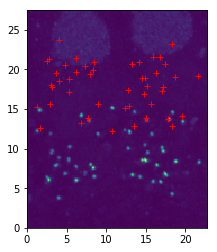

In [10]:
pl.imshow(projection_cropped, extent=extent)
pl.plot(stats_CtBP2['X'], stats_CtBP2['Y'], 'r+')

Uh oh. The image (or the statistics) looks like it's flipped along the Y-axis. Let's take another look at the `imshow` documentation. What does it say? Any clues to how to fix this?

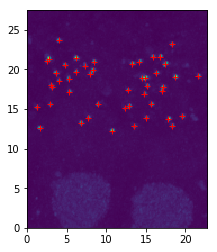

In [11]:
pl.imshow(projection_cropped, extent=extent, origin='lower left')
pl.plot(stats_CtBP2['X'], stats_CtBP2['Y'], 'r+')

We want to use this data to extract a 1$\mu m$ x 1$\mu m$ x 1$\mu m$ cube centered around each puncta. To do this we need to convert from $\mu m$ to pixels. Since we know the dimensions in pixels and $\mu m$, we can calculate the size of each pixel.

In [12]:
x_size = x_um/x_pixels
y_size = y_um/y_pixels
z_size = z_um/z_pixels
print(x_size, y_size, z_size)

0.14125341614906833 0.14145360824742267 0.15945185185185184


This means that each pixel along the X and Y axes are 0.14 $\mu m$ and the Z axis is 0.16 $\mu m$. If we want to convert from $\mu m$ to pixels, we can simply divide by the pixel size. This means that a 1$\mu m$ x 1$\mu m$ x 1$\mu m$ cube is approximately 7 x 7 x 6 pixels in size (rounded to the nearest pixel).

Let's pull out the first puncta in the dataframe and plot the maximum projection.

In [13]:
puncta = stats_CtBP2.iloc[0]
puncta

name
X     6.832067
Y    13.227180
Z     3.471509
Name: 0, dtype: float64

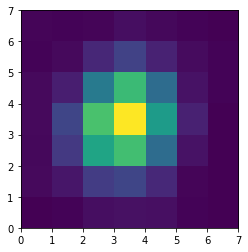

In [14]:
x_loc = int(puncta['X']/x_size)
y_loc = int(puncta['Y']/y_size)
z_loc = int(puncta['Z']/z_size)

subset_CtBP2 = data_CtBP2[z_loc-3:z_loc+3, y_loc-3:y_loc+4, x_loc-3:x_loc+4]
subset_projection = subset_CtBP2.max(axis=0)
pl.imshow(subset_projection, extent=(0, 7, 0, 7))

Looks like we've adequately identified the cube we need. Now, let's load the GluR2 data so we can plot the amount of GluR2 signal within this region.

In [15]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Data')
data_GluR2 = node.read()
data_GluR2 = data_GluR2[:z_pixels, :y_pixels, :x_pixels]

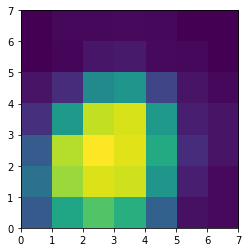

In [16]:
subset_GluR2 = data_GluR2[z_loc-3:z_loc+3, y_loc-3:y_loc+4, x_loc-3:x_loc+4]
subset_projection = subset_GluR2.max(axis=0)
pl.imshow(subset_projection, extent=(0, 7, 0, 7))

Looks like there's some GluR2 signal next to the CtBP2 signal. Great! Now how do we quantify this? Maybe we can just take the average intensity within this GluR2 subset?

In [17]:
subset_GluR2.mean()

33.642857142857146

Seems reasonable. The next step would be to loop through each row (i.e., puncta) in the dataframe and extract the mean GluR2 signal. This can then be saved back as a new column in the dataframe. We can loop through the rows using the `iterrows` method. 

In [18]:
signal = []
for _, puncta in stats_CtBP2.iterrows():
    x_loc = int(puncta['X']/x_size)
    y_loc = int(puncta['Y']/y_size)
    z_loc = int(puncta['Z']/z_size)
    subset_GluR2 = data_GluR2[z_loc-3:z_loc+3, y_loc-3:y_loc+4, x_loc-3:x_loc+4]
    signal.append(subset_GluR2.mean())
    
stats_CtBP2['GluR2'] = signal

Now, let's plot a histogram of the GluR2 signal near each CtBP2 puncta.

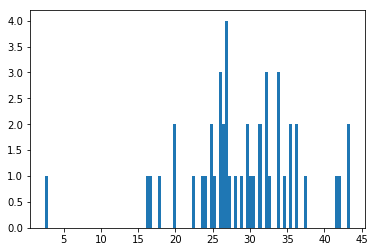

In [19]:
pl.hist(stats_CtBP2['GluR2'], bins=100);

Looks like there's an obvious cutoff threshold we can use (i.e., < 10). How many functional synapses are there?

In [20]:
mask = stats_CtBP2['GluR2'] > 10
len(stats_CtBP2[mask])

46

## Bonus - Creating a composite image

In the above images, `imshow` is using a color map in which purple reflects the regions with no signal and yellow reflects regions with the most signal. But, what if we'd like to merge the three channels into a single image where red is mapped to CtBP2, green to GluR2 and blue to MyosinVIIa. How can we do this? Let's take another look at the documentation for `imshow`.

In [21]:
pl.imshow?

It looks `imshow` can take a 3D array where the last dimension maps to the three colors (i.e., `x[..., 0]` is red, `x[..., 1]` is green and `x[..., 2]` is blue). The documentation also warns that the values in the array must be in the range 0 ... 1 for this to work. Let's check that. 

In [22]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data')
data_CtBP2 = node.read()
data_CtBP2 = data_CtBP2[:z_pixels, :y_pixels, :z_pixels]
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Data')
data_GluR2 = node.read()
data_GluR2 = data_GluR2[:z_pixels, :y_pixels, :z_pixels]

In [23]:
data_CtBP2.max()

253

Uh oh. We need to fix that. The simplest way to coerce data to the range 0 ... 1 is to divide by the maximum value. Let's do this and check that we did OK.

In [24]:
data_CtBP2 = data_CtBP2/np.max(data_CtBP2)
data_GluR2 = data_GluR2/np.max(data_GluR2)

In [25]:
data_CtBP2.max()

1.0

Great. Now we need to make the 2D image for each color and then merge them into a 3D array. A list of 2D images can be stacked into a 3D array using Numpy's `dstack` function. We need to make a blank image for the blue color. The quickest way to do this is to use the `zeros_like` function from Numpy which will create an array of the same shape, but filled with zeros.

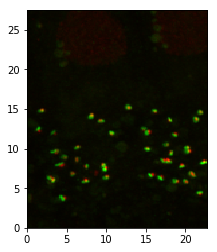

In [26]:
projection_CtBP2 = data_CtBP2.max(axis=0)
projection_GluR2 = data_GluR2.max(axis=0)
projection_blue = np.zeros_like(projection_CtBP2)

data = [projection_CtBP2, projection_GluR2, projection_blue]
projection = np.dstack(data)

pl.imshow(projection, extent=extent)